In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm
from tqdm import tqdm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 30
mtype = 'assetcov_gics'

with open("../../mlr_fitting_private/data_finance/crsp_gics_5k_hpart.pkl", "rb") as f:
       gics_hpart = pickle.load(f)

with open('../../mlr_fitting_private/data_finance/crsp_gics_5k_C.npy', 'rb') as f:
       C = np.load(f)

m = n = gics_hpart['rows']['pi'].size
part_sizes = []
for level in range(len(gics_hpart['rows']['lk'])):
    part_sizes += [gics_hpart['rows']['lk'][level].size-1]
    print(f"{level=}, {gics_hpart['rows']['lk'][level].size-1}")

Z = mf.demean_clip(C)
# features are presented in general order
unpermuted_A = Z @ Z.T / (Z.shape[1]-1)

level=0, 1
level=1, 11
level=2, 24
level=3, 69
level=4, 157
level=5, 5000


In [4]:
np.sort(np.abs(np.linalg.eigvalsh(unpermuted_A)))[::-1][:10]

array([1.80995933, 0.24351866, 0.17073495, 0.11152992, 0.08905731,
       0.080994  , 0.06320885, 0.05705067, 0.05527067, 0.05144684])

In [5]:
np.histogram(np.sort(np.abs(np.linalg.eigvalsh(unpermuted_A)))[::-1][:100], bins=8)

(array([99,  0,  0,  0,  0,  0,  0,  1]),
 array([0.02193369, 0.24543689, 0.4689401 , 0.6924433 , 0.91594651,
        1.13944971, 1.36295292, 1.58645612, 1.80995933]))

In [6]:
C.shape, unpermuted_A.shape, unpermuted_A.min(), unpermuted_A.max(), unpermuted_A.mean(), unpermuted_A.std()

((5000, 300),
 (5000, 5000),
 -0.001839477534559251,
 0.014836883129622934,
 0.0002737358427138843,
 0.00025728376347159727)

In [7]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [8]:
# GICS hierarchy
num_levels = len(gics_hpart['rows']['lk'])

In [ ]:
# permute to put clusters on diagonal
Y = Z[gics_hpart["rows"]["pi"], :].T
N = Y.shape[0]

In [10]:
Y.mean(), Y.max(), Y.min(), np.median(Y)

(-0.00027599359051962765,
 1.7531290483245723,
 -0.6189932233333333,
 -0.0006269800000000001)

In [10]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(gics_hpart)

num_levels=6, num_sparsities=157
(157, 5) [  0  10  23  68 156]


In [11]:
obj_frobs = {}
obj_mle = {}

# $[29, 0, 0, 0, 0, 1]$

In [12]:
ranks = np.array([rank-1, 0, 0, 0, 0, 1])

# Frobenius norm

In [13]:
obj_frobs[str(ranks)] = mfm.frob_fit_loglikehood(unpermuted_A, Y, F_hpart, gics_hpart, ranks, printing=True, eps_ff=1e-3)

/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.1541325347909012, [29  0  0  0  0  1]
itr=1, 0.1541325347909012, [29  0  0  0  0  1]
itr=1, 0.15379449543341234, [29  0  0  0  0  1], time_v_epoch=5.398721218109131, time_loss=0.3282480239868164
itr=2, 0.15379249118337152, [29  0  0  0  0  1], time_v_epoch=5.476085901260376, time_loss=0.40348196029663086
FR: obj_frob = 11808.872096245648
mf.rel_diff(hat_A.matrix(), den=A)=0.15379235173974629 
np.linalg.slogdet(hat_A.matrix())=(1.0, -37702.343185018195)


# MLE

In [14]:
loglikelihoods, F0, D0 = mfm.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, 
                                         ranks, max_iter=100, eps=1e-8, printing=True, 
                                         F0=np.random.randn(n, rank-1), 
                                         D0=np.square(np.random.rand(n))+1)

Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
print(mf.rel_diff(Sigma0, den=unpermuted_A[F_hpart["pi"], :][:, F_hpart["pi"]]), np.linalg.slogdet(Sigma0))
obj_mle[str(ranks)] = np.array(loglikelihoods)

t=0, obj=-5372.454935431251
t=50, obj=11904.572004989695
t=99, obj=11905.189933020913
32.53751658632977 (1.0, -37995.63677865609)


# $[14, 6, 4, 3, 2, 1]$

In [15]:
ranks = np.array([14, 6, 4, 3, 2, 1])

# Frobenius norm

In [16]:
# Frobenius norm
obj_frobs[str(ranks)] = mfm.frob_fit_loglikehood(unpermuted_A, Y, F_hpart, gics_hpart, ranks, printing=True, eps_ff=1e-3)

itr=0, 0.16617119653534937, [14  6  4  3  2  1]
itr=1, 0.16617119653534937, [14  6  4  3  2  1]
itr=1, 0.16493897439347802, [14  6  4  3  2  1], time_v_epoch=5.645741701126099, time_loss=0.33407115936279297
itr=2, 0.16482424552301322, [14  6  4  3  2  1], time_v_epoch=8.150538921356201, time_loss=0.3450169563293457
FR: obj_frob = 11955.956851218816
mf.rel_diff(hat_A.matrix(), den=A)=0.16479092911663543 
np.linalg.slogdet(hat_A.matrix())=(1.0, -38056.193412982)


In [17]:
# LR             0.16178478761767232
# LR+D           0.1537922868665804

# MLE

In [18]:
loglikelihoods, F0, D0 = mfm.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, 
                                         ranks, max_iter=100, eps=1e-8, printing=True, 
                                         F0=np.random.randn(n, rank-1), 
                                         D0=np.square(np.random.rand(n))+1)

Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
print(mf.rel_diff(Sigma0, den=unpermuted_A[F_hpart["pi"], :][:, F_hpart["pi"]]), np.linalg.slogdet(Sigma0))
obj_mle[str(ranks)] = np.array(loglikelihoods)

t=0, obj=-6498.263822822442
t=50, obj=12105.393429477026
t=99, obj=12112.426422430344
6.147128903870216 (1.0, -38409.02905043134)


In [28]:
# hier MLE 
(12112.426422430344 - 11955.956851218816)

156.4695712115281

In [31]:
12112 - 11956, 11905 - 11809

(156, 96)

In [29]:
# factor MLE
11905.189933020913 - 11808.872096245648

96.31783677526437

ranks=array([29,  0,  0,  0,  0,  1]), difference=96.32, %increase=0.82
ranks=array([14,  6,  4,  3,  2,  1]), difference=156.47, %increase=1.31


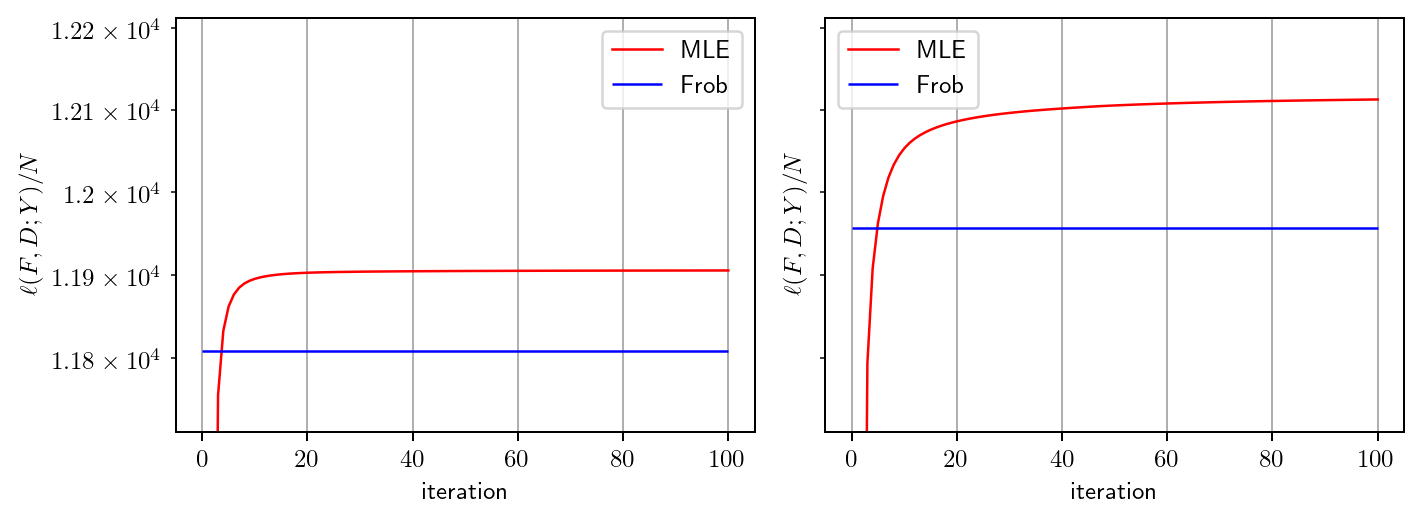

In [27]:
rs = [np.array([rank-1, 0, 0, 0, 0, 1]), np.array([14, 6, 4, 3, 2, 1])]
# ll_all = [ll_factor, ll_hier]
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
ylim = [obj_mle[str(rs[1])].max()-400, obj_mle[str(rs[1])].max() + 100]
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=180, sharey=True)
for i in range(2):
    ranks = rs[i]
    ll = obj_mle[str(rs[i])]
    print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)])/obj_frobs[str(ranks)]*100:.2f}")
    axs[i].plot(np.maximum(1, ll), color='r', lw=1, label=r"$\text{MLE}$")
    axs[i].set_xlabel('iteration')
    axs[i].hlines(obj_frobs[str(ranks)], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
    axs[i].set_ylabel(r'$\ell(F, D; Y)/N$')
    axs[i].set_yscale('log')
    axs[i].set_ylim(ylim)
    axs[i].grid(True)
    axs[i].legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
# fig.suptitle("Observed data log-likelihood", fontsize=16, y=1.05)
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [ ]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"mle":obj_mle,  "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(f"outputs/em_{mtype}.pickle", 'rb') as handle:
    mlls = pickle.load(handle)

In [ ]:
mlls.keys()

In [32]:
mf.convert_compressed_to_sparse(F0, F_hpart, ranks[:-1]).toarray().shape

(5000, 697)